In [1]:
import sys
sys.path.append('../code') 
import mocap_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from sklearn.model_selection import ShuffleSplit
import scipy.io as sio


/home/ntolley/anaconda3/envs/SEE_vision/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_path = '../data/SPK20220308/task_data/'
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df(data_path)
video_df = pd.read_pickle(data_path + 'video_df.pkl')


num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [22]:
reader = torchvision.io.VideoReader('../data/SPK20220308/videos/SpikeCam1_03-08-1557.mp4', 'video')

In [33]:
analog_sampling_rate = 1000
cam_frames = np.load('cam_frames.npy')

fpath = '../data/SPK20220308/task_data/'
experiment_dict = sio.loadmat(f'{fpath}eventsCB1_corrected.mat')
ev_ex = experiment_dict['eventsCB1']

cam_start = cam_frames[0] / analog_sampling_rate

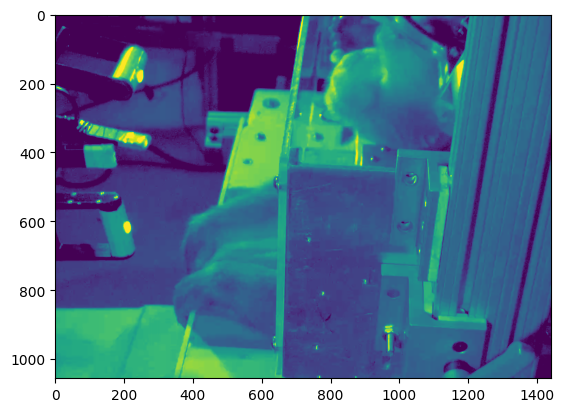

In [43]:
reader.seek(video_df['frames'][40][10] - cam_start, )
frame = next(reader)
plt.imshow(frame['data'].numpy()[0,:,:])

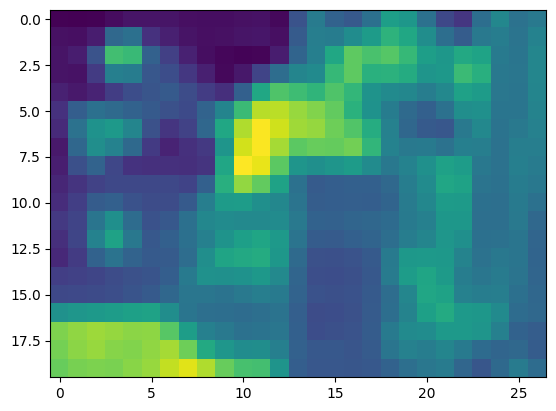

In [59]:
pooler = torch.nn.AvgPool2d(kernel_size=100, stride=50)
frame_pooled = pooler(frame['data'].float())
plt.imshow(frame_pooled[0,:,:])

In [10]:
#Dataset class to handle mocap dataframes from SEE project
class SEE_Video_Dataset(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, cv_dict, fold, partition, video_df, neural_df, offset, window_size, data_step_size, device,
                 scale_neural=True, flip_outputs=False):
        #'Initialization'
        self.cv_dict = cv_dict
        self.fold = fold
        self.flip_outputs = flip_outputs
        self.partition = partition
        self.trial_idx = cv_dict[fold][partition]
        self.num_trials = len(self.trial_idx) 
        self.offset = offset
        self.window_size = window_size
        self.data_step_size = data_step_size
        self.device = device
        self.posData_list, self.neuralData_list = self.process_dfs(video_df, neural_df)

        # Boolean array of 1's for features to not be scaled
        
        if scale_neural:
            self.neuralData_list = self.transform_data(self.neuralData_list)

        self.split_offset = np.round((self.offset/self.data_step_size) / 2).astype(int)

        self.X_tensor, self.y_tensor = self.load_splits()
        self.num_samples = np.sum(self.X_tensor.size(0))

    def __len__(self):
        #'Denotes the total number of samples'
        return self.num_samples

    def __getitem__(self, slice_index):
        return self.X_tensor[slice_index,:,:], self.y_tensor[slice_index,:,:]

    #**add functionality to separate eye, object, and body markers
    def process_dfs(self, video_df, neural_df):
        posData_list, neuralData_list = [], []
        for trial in self.trial_idx:
            posData_array = np.stack(video_df['posData'][video_df['trial'] == trial].values).transpose() 
            neuralData_array = np.stack(neural_df['rates'][neural_df['trial'] == trial].values).squeeze().transpose() 

            posData_list.append(posData_array)
            neuralData_list.append(neuralData_array)

        return posData_list, neuralData_list

    def format_splits(self, data_list):
        unfolded_data_list = list()
        for trial_idx in range(self.num_trials):
            unfolded_trial = torch.from_numpy(data_list[trial_idx]).unfold(0, self.window_size, self.data_step_size).transpose(1, 2)
            unfolded_data_list.append(unfolded_trial)
        
        data_tensor = torch.concat(unfolded_data_list, axis=0)

        return data_tensor
    
    def load_splits(self):
        if not self.flip_outputs:
            X_tensor = self.format_splits(self.posData_list)
            y_tensor = self.format_splits(self.neuralData_list)
        else:
            y_tensor = self.format_splits(self.posData_list)
            X_tensor = self.format_splits(self.neuralData_list)

        X_tensor, y_tensor = X_tensor[:-self.split_offset,::self.data_step_size,:], y_tensor[self.split_offset:,::self.data_step_size,:]
        assert X_tensor.shape[0] == y_tensor.shape[0]
        return X_tensor, y_tensor

    #Zero mean and unit std
    def transform_data(self, data_list, exclude_processing):
        #Iterate over trials and apply normalization
     
        scaled_data_list = []
        for data_trial in data_list:
            if exclude_processing is None:
                scaled_data_trial = scaler.fit_transform(data_trial)
            else: 
                scaled_data_trial = np.zeros(data_trial.shape)
                scaled_data_trial[:, exclude_processing] = data_trial[:, exclude_processing]
                processed_data = scaler.fit_transform(data_trial[:, ~exclude_processing])
                scaled_data_trial[:, ~exclude_processing] = processed_data
            scaled_data_list.append(scaled_data_trial)

        return scaled_data_list